# Demo - White Box Attack (Imagenet)

In [1]:
import numpy as np
import json
import os
import sys
import time
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision.utils
from torchvision import models
import torchvision.datasets as dsets
import torchvision.transforms as transforms

import torchattacks

from utils import imshow, image_folder_custom_label

In [2]:
print("PyTorch", torch.__version__)
print("Torchvision", torchvision.__version__)
print("Torchattacks", torchattacks.__version__)
print("Numpy", np.__version__)

PyTorch 1.9.1+cu102
Torchvision 0.10.1+cu102
Torchattacks 3.2.4
Numpy 1.19.5


## 1. Load Data

In [3]:
# https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json
class_idx = json.load(open("./data/imagenet_class_index.json"))
idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]

In [4]:
transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(), # ToTensor : [0, 255] -> [0, 1]
    
# Using normalization for Inception v3.
# https://discuss.pytorch.org/t/how-to-preprocess-input-for-pre-trained-networks/683
#     transforms.Normalize(mean=[0.485, 0.456, 0.406],                     
#                          std=[0.229, 0.224, 0.225])
    
# However, DO NOT USE normalization transforms here.
# Torchattacks only supports images with a range between 0 and 1.
# Thus, please refer to the model construction section.
    
])

In [5]:
imagnet_data = image_folder_custom_label(root='./data/imagenet', transform=transform, idx2label=idx2label)
data_loader = torch.utils.data.DataLoader(imagnet_data, batch_size=1, shuffle=False)

True Image & True Label


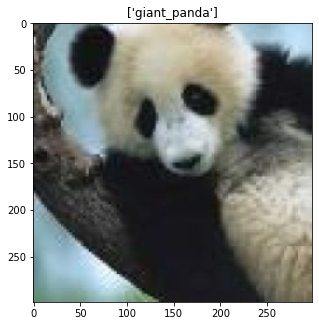

In [6]:
images, labels = iter(data_loader).next()

print("True Image & True Label")
imshow(torchvision.utils.make_grid(images, normalize=True), [imagnet_data.classes[i] for i in labels])

## 2. Load Inception v3

In [7]:
class Normalize(nn.Module):
    def __init__(self, mean, std) :
        super(Normalize, self).__init__()
        self.register_buffer('mean', torch.Tensor(mean))
        self.register_buffer('std', torch.Tensor(std))
        
    def forward(self, input):
        # Broadcasting
        mean = self.mean.reshape(1, 3, 1, 1)
        std = self.std.reshape(1, 3, 1, 1)
        return (input - mean) / std

In [8]:
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")

In [9]:
# Adding a normalization layer for Resnet18.
# We can't use torch.transforms because it supports only non-batch images.
norm_layer = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

model = nn.Sequential(
    norm_layer,
    models.resnet18(pretrained=True)
).to(device)

model = model.eval()

## 3. Adversarial Attack

In [10]:
from torchattacks import *

In [11]:
atks = [
    FGSM(model, eps=8/255),
    BIM(model, eps=8/255, alpha=2/255, steps=100),
    RFGSM(model, eps=8/255, alpha=2/255, steps=100),
    CW(model, c=1, lr=0.01, steps=100, kappa=0),
    PGD(model, eps=8/255, alpha=2/225, steps=100, random_start=True),
    PGDL2(model, eps=1, alpha=0.2, steps=100),
    EOTPGD(model, eps=8/255, alpha=2/255, steps=100, eot_iter=2),
    FFGSM(model, eps=8/255, alpha=10/255),
    TPGD(model, eps=8/255, alpha=2/255, steps=100),
    MIFGSM(model, eps=8/255, alpha=2/255, steps=100, decay=0.1),
    VANILA(model),
    GN(model, std=0.1),
    APGD(model, eps=8/255, steps=100, eot_iter=1, n_restarts=1, loss='ce'),
    APGD(model, eps=8/255, steps=100, eot_iter=1, n_restarts=1, loss='dlr'),
    APGDT(model, eps=8/255, steps=100, eot_iter=1, n_restarts=1),
    FAB(model, eps=8/255, steps=100, n_classes=10, n_restarts=1, targeted=False),
    FAB(model, eps=8/255, steps=100, n_classes=10, n_restarts=1, targeted=True),
    Square(model, eps=8/255, n_queries=5000, n_restarts=1, loss='ce'),
    AutoAttack(model, eps=8/255, n_classes=10, version='standard'),
    OnePixel(model, pixels=5, inf_batch=50),
    DeepFool(model, steps=100),
    DIFGSM(model, eps=8/255, alpha=2/255, steps=100, diversity_prob=0.5, resize_rate=0.9)
]

Adversarial Image & Predicted Label
----------------------------------------------------------------------
FGSM(model_name=Sequential, device=cuda:0, eps=0.03137254901960784, attack_mode=default, return_type=float)


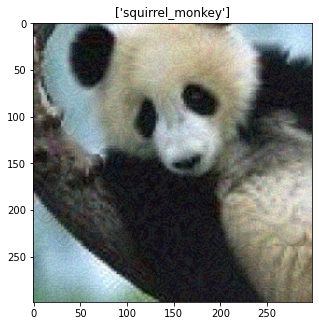

Total elapsed time (sec): 1.32
Robust accuracy: 0.00 %
----------------------------------------------------------------------
BIM(model_name=Sequential, device=cuda:0, eps=0.03137254901960784, alpha=0.00784313725490196, steps=100, attack_mode=default, return_type=float)


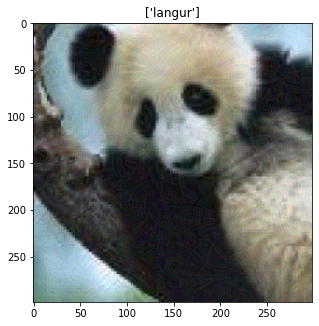

Total elapsed time (sec): 0.86
Robust accuracy: 0.00 %
----------------------------------------------------------------------
RFGSM(model_name=Sequential, device=cuda:0, eps=0.03137254901960784, alpha=0.00784313725490196, steps=100, attack_mode=default, return_type=float)


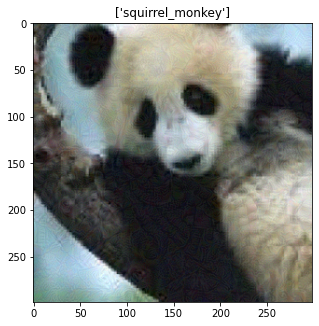

Total elapsed time (sec): 0.79
Robust accuracy: 0.00 %
----------------------------------------------------------------------
CW(model_name=Sequential, device=cuda:0, c=1, kappa=0, steps=100, lr=0.01, attack_mode=default, return_type=float)


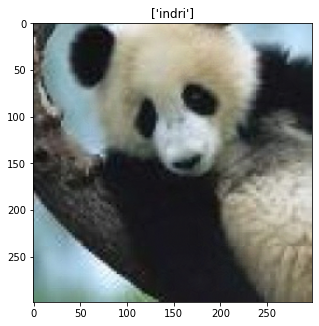

Total elapsed time (sec): 0.29
Robust accuracy: 0.00 %
----------------------------------------------------------------------
PGD(model_name=Sequential, device=cuda:0, eps=0.03137254901960784, alpha=0.008888888888888889, steps=100, random_start=True, attack_mode=default, return_type=float)


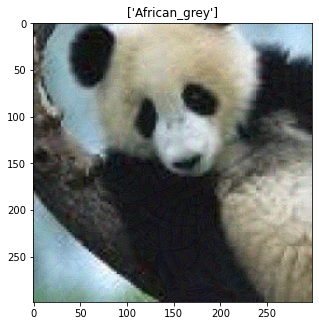

Total elapsed time (sec): 0.81
Robust accuracy: 0.00 %
----------------------------------------------------------------------
PGDL2(model_name=Sequential, device=cuda:0, eps=1, alpha=0.2, steps=100, random_start=True, eps_for_division=1e-10, attack_mode=default, return_type=float)


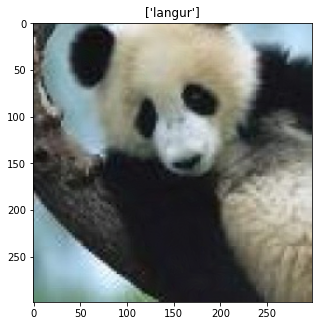

Total elapsed time (sec): 0.84
Robust accuracy: 0.00 %
----------------------------------------------------------------------
EOTPGD(model_name=Sequential, device=cuda:0, eps=0.03137254901960784, alpha=0.00784313725490196, steps=100, eot_iter=2, random_start=True, attack_mode=default, return_type=float)


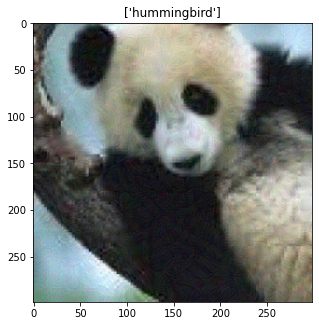

Total elapsed time (sec): 1.44
Robust accuracy: 0.00 %
----------------------------------------------------------------------
FFGSM(model_name=Sequential, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)


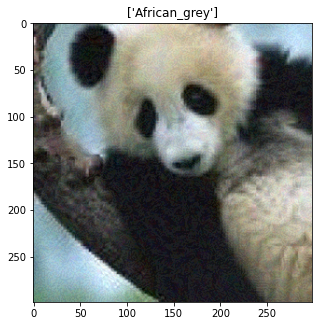

Total elapsed time (sec): 0.26
Robust accuracy: 0.00 %
----------------------------------------------------------------------
TPGD(model_name=Sequential, device=cuda:0, eps=0.03137254901960784, alpha=0.00784313725490196, steps=100, attack_mode=default, return_type=float)


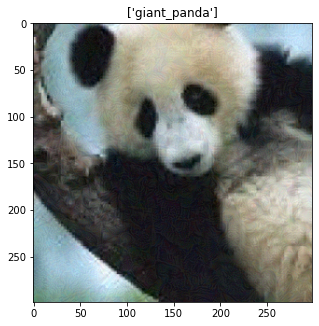

Total elapsed time (sec): 0.82
Robust accuracy: 100.00 %
----------------------------------------------------------------------
MIFGSM(model_name=Sequential, device=cuda:0, eps=0.03137254901960784, steps=100, decay=0.1, alpha=0.00784313725490196, attack_mode=default, return_type=float)


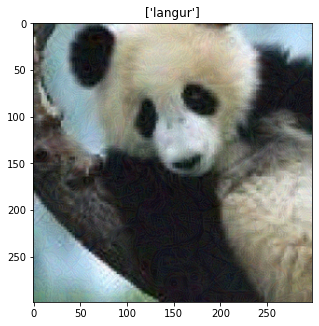

Total elapsed time (sec): 0.87
Robust accuracy: 0.00 %
----------------------------------------------------------------------
VANILA(model_name=Sequential, device=cuda:0, attack_mode=default, return_type=float)


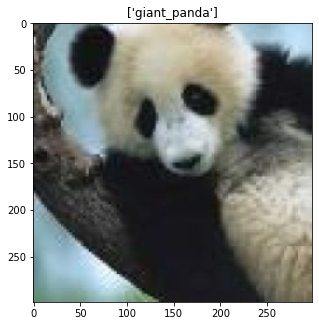

Total elapsed time (sec): 0.21
Robust accuracy: 100.00 %
----------------------------------------------------------------------
GN(model_name=Sequential, device=cuda:0, std=0.1, attack_mode=default, return_type=float)


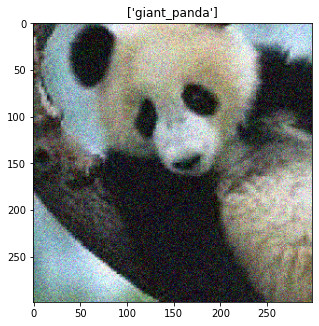

Total elapsed time (sec): 0.18
Robust accuracy: 100.00 %
----------------------------------------------------------------------
APGD(model_name=Sequential, device=cuda:0, eps=0.03137254901960784, steps=100, norm=Linf, n_restarts=1, seed=0, loss=ce, eot_iter=1, thr_decr=0.75, verbose=False, attack_mode=default, return_type=float)


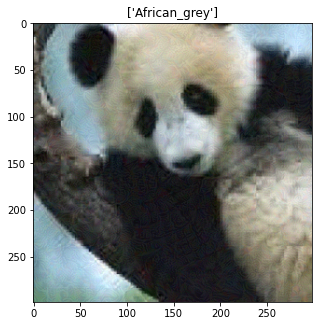

Total elapsed time (sec): 1.04
Robust accuracy: 0.00 %
----------------------------------------------------------------------
APGD(model_name=Sequential, device=cuda:0, eps=0.03137254901960784, steps=100, norm=Linf, n_restarts=1, seed=0, loss=dlr, eot_iter=1, thr_decr=0.75, verbose=False, attack_mode=default, return_type=float)


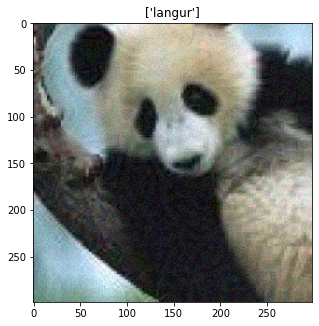

Total elapsed time (sec): 1.14
Robust accuracy: 0.00 %
----------------------------------------------------------------------
APGDT(model_name=Sequential, device=cuda:0, eps=0.03137254901960784, steps=100, norm=Linf, n_restarts=1, seed=0, eot_iter=1, thr_decr=0.75, verbose=False, target_class=None, n_target_classes=9, attack_mode=default, return_type=float)


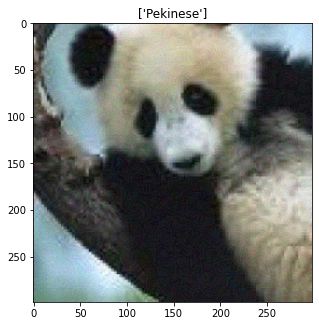

Total elapsed time (sec): 1.23
Robust accuracy: 0.00 %
----------------------------------------------------------------------
FAB(model_name=Sequential, device=cuda:0, norm=Linf, n_restarts=1, eps=0.03137254901960784, alpha_max=0.1, eta=1.05, beta=0.9, steps=100, targeted=False, verbose=False, seed=0, target_class=None, n_target_classes=9, attack_mode=default, return_type=float)


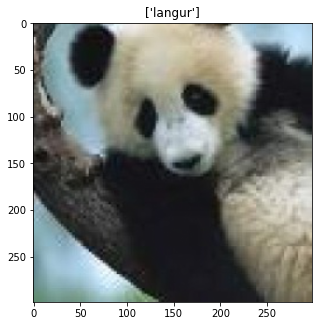

Total elapsed time (sec): 15693.57
Robust accuracy: 0.00 %
----------------------------------------------------------------------
FAB(model_name=Sequential, device=cuda:0, norm=Linf, n_restarts=1, eps=0.03137254901960784, alpha_max=0.1, eta=1.05, beta=0.9, steps=100, targeted=False, verbose=False, seed=0, target_class=None, n_target_classes=9, attack_mode=default, return_type=float)


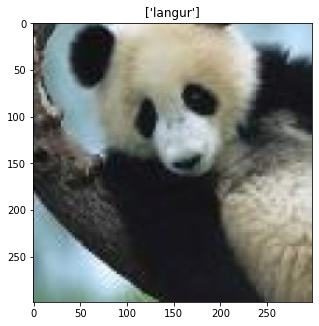

Total elapsed time (sec): 780.09
Robust accuracy: 0.00 %
----------------------------------------------------------------------
Square(model_name=Sequential, device=cuda:0, norm=Linf, n_queries=5000, eps=0.03137254901960784, p_init=0.8, n_restarts=1, seed=0, verbose=False, loss=ce, rescale_schedule=True, attack_mode=default, return_type=float)


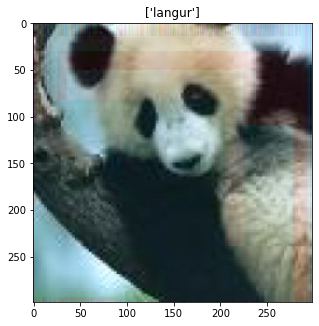

Total elapsed time (sec): 0.63
Robust accuracy: 0.00 %
----------------------------------------------------------------------
AutoAttack(model_name=Sequential, device=cuda:0, norm=Linf, eps=0.03137254901960784, version=standard, n_classes=10, seed=None, verbose=False, autoattack=MultiAttack(model_name=Sequential, device=cuda:0, attacks=[<torchattacks.attacks.apgd.APGD object at 0x00000196462292E0>, <torchattacks.attacks.apgdt.APGDT object at 0x00000196462292B0>, <torchattacks.attacks.fab.FAB object at 0x0000019646229340>, <torchattacks.attacks.square.Square object at 0x0000019646229370>], verbose=False, attack_mode=default, return_type=float), attack_mode=default, return_type=float)


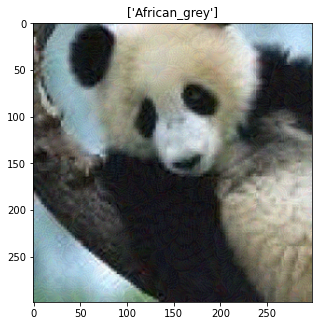

Total elapsed time (sec): 20.03
Robust accuracy: 0.00 %
----------------------------------------------------------------------
OnePixel(model_name=Sequential, device=cuda:0, pixels=5, steps=75, popsize=400, inf_batch=50, attack_mode=default, return_type=float)


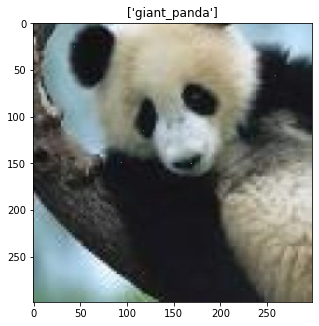

Total elapsed time (sec): 545.33
Robust accuracy: 100.00 %
----------------------------------------------------------------------
DeepFool(model_name=Sequential, device=cuda:0, steps=100, overshoot=0.02, attack_mode=default, return_type=float)


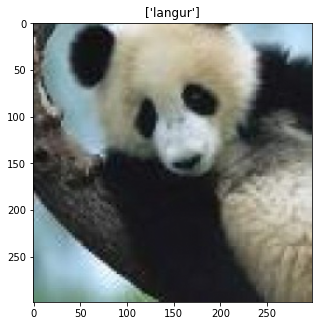

Total elapsed time (sec): 751.83
Robust accuracy: 0.00 %
----------------------------------------------------------------------
DIFGSM(model_name=Sequential, device=cuda:0, eps=0.03137254901960784, steps=100, decay=0.0, alpha=0.00784313725490196, resize_rate=0.9, diversity_prob=0.5, random_start=False, attack_mode=default, return_type=float)


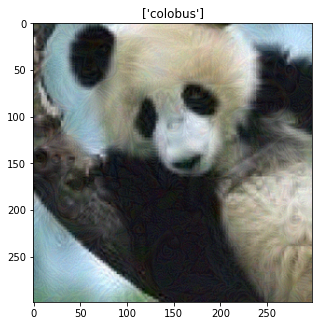

Total elapsed time (sec): 2.02
Robust accuracy: 0.00 %


In [12]:
print("Adversarial Image & Predicted Label")

for atk in atks :
    
    print("-"*70)
    print(atk)
    
    correct = 0
    total = 0
    start = time.time()
    
    for images, labels in data_loader:
        adv_images = atk(images, labels)
        labels = labels.to(device)
        outputs = model(adv_images)

        _, pre = torch.max(outputs.data, 1)

        total += 1
        correct += (pre == labels).sum()

        imshow(torchvision.utils.make_grid(adv_images.cpu().data, normalize=True), [imagnet_data.classes[i] for i in pre])

    print('Total elapsed time (sec): %.2f' % (time.time() - start))
    print('Robust accuracy: %.2f %%' % (100 * float(correct) / total))